# Intro

Trying to build simple density estimators from scratch using only numpy. These estimators are tested on the classic iris dataset

# Estimator classes

### Super-class for both estimators

In [7]:
import numpy as np


class GaussianDiag:
    def train(self, train_data, sigma=None):
        """ Performs operations common to both train() methods
        Args:
            train_data (nxd numpy.array)
            sigma(1xd numpy.array) Optional. Diagonal elements of the covariance matrix
        """
        self.train_data = np.array(train_data)

        # Diagonal elements of covariance matrix
        if isinstance(sigma,(int,float)): #Isotropic Gaussian
            sigma_array = np.repeat(sigma,self.train_data.shape[1])
        elif sigma == None: # Parametric Gaussian
            sigma_array = np.std(self.train_data, axis=0)
        else :
            sigma_array = np.array(sigma)

        assert sigma_array.ndim <= 1, "sigma must be a 1xd vector of the diagonal elements of the covariance matrix"
        # Array containing 1/(sqrt(2*pi)*sigma_j) for j in {1,...,d}
        self.constants = (np.sqrt(np.pi * 2.0) * sigma_array) ** -1

        # Array containing exp(-1/2*sigma_j^2) for j in {1,...,d}
        self.exps = np.exp((-2 * sigma_array**2)**-1)

    def log_density(self, x, x2):
        """Returns the Gaussian Diagonal log-density estimation

        Can be used for both parametric (x2 = mu) and Parzen (x2 = training point) estimators

        Args:
            x (1xd numpy.array) Test example
            x2 (1xd or nxd numpy.array) "Center" of the Gaussian (e.g. mu or training point(s))

        Returns:
            (float) log-density estimation
        """
        x_array = np.array(x)

        x2_array = np.array(x2)

        prod = np.prod(self.constants * np.power(self.exps, (x_array - x2_array)**2),
                       axis=1 if x2_array.ndim > 1 else None)  # formula from Question 3-4a)

        # if x2 is a vector, prod is a scalar => np.mean = prod. if x2 is a matrix, prod is a vector containing the products for x_1 to x_n respectively => np.mean = 1/n * sum of prods
        density = np.mean(prod)

        return np.log(density)

### Diagonal Gaussian Parametric Density Estimator

In [8]:
class GaussianDiagParametric(GaussianDiag):
    def train(self,train_data):
        super().train(train_data)

    def predict(self, x):
        """Predicts the log-density using mu as the center of the distribution

        Args:
            x (numpy.array) Test example
        Returns:
            (float) log-density estimation
        """
        mu = np.mean(self.train_data, axis=0)
        return self.log_density(x, mu)

### Parzen Density Estimator with Diagonal Gaussian Kernel

In [9]:
class GaussianDiagParzen(GaussianDiag):
    def train(self,train_data,sigma):
        super().train(train_data,sigma=sigma)

    def predict(self, x):
        """Predicts the mean log-density using each training point as the center of the distribution

        Args:
            x (numpy.array) Test example
        Returns:
            (float) log-density estimation
        """
        return self.log_density(x, self.train_data)

class GaussianIsoParzen(GaussianDiagParzen):
    """Same as GaussianDiagParzen. This is just to make it clear that the class allows isotropic Gaussians"""

# Density estimation on the iris dataset

## 1-dimensional, 1-class distribution

### Load data

In [10]:
iris = np.loadtxt('iris.txt')
class_chosen = 1
feature_chosen = 0
first_row = 50 * (class_chosen - 1)
last_row = first_row + 50
data = np.vstack(iris[first_row:last_row, feature_chosen])

### Prepare grid

In [11]:
min_x = np.min(data)
max_x = np.max(data)
x_grid = np.vstack(np.linspace(min_x, max_x,num=100))

### Training

#### Parametric estimator

In [12]:
param = GaussianDiagParametric()

param.train(data)
# since predict() gives the log-density, we need to get the exp of predict()
param_y = np.exp(np.apply_along_axis(param.predict, 1, x_grid))

#### Parzen with different $\sigma$

In [13]:
parzen = GaussianIsoParzen()

parzen.train(data, 0.1)
# since predict() gives thelog-density, we need to get the exp of predict()
parzen_small_y = np.exp(np.apply_along_axis(parzen.predict, 1, x_grid))

In [14]:
parzen.train(data, 0.6)
# since predict() gives the log-density, we need to get the exp of predict()
parzen_big_y = np.exp(np.apply_along_axis(parzen.predict, 1, x_grid))

In [15]:
# Silverman's rule of thumb: sigma = 1.06*sigma_hat*n^(-0.2)
sigma_silverman = 1.06 * np.std(data) * data.shape[0]**-0.2
parzen.train(data, sigma_silverman)
# since predict() gives the log-density, we need to get the exp of predict()
parzen_final_y = np.exp(np.apply_along_axis(parzen.predict, 1, x_grid))

### Plot results

/home/owner/miniconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:232: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


Populating the interactive namespace from numpy and matplotlib


/home/owner/miniconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['pylab']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


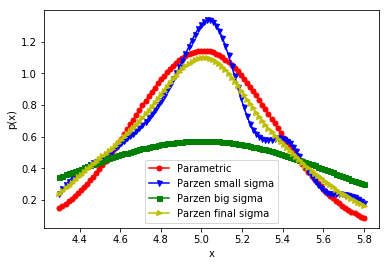

In [16]:
import pylab
%pylab inline
h1, = pylab.plot(x_grid, param_y, marker="o", c="r", ms=5)
h2, = pylab.plot(x_grid, parzen_small_y, marker="v", c="b", ms=5)
h3, = pylab.plot(x_grid, parzen_big_y, marker="s", c="g", ms=5)
h4, = pylab.plot(x_grid, parzen_final_y, marker=">", color="y", ms=5)
handles = (h1, h2, h3, h4)
labels = ("Parametric", "Parzen small sigma", "Parzen big sigma", "Parzen final sigma")
pylab.legend(handles, labels)
pylab.xlabel("x")
pylab.ylabel("p(x)")
pylab.show()

## 2-dimensional, 1-class distribution

### Load data

In [17]:
class_chosen = 1
features_chosen = (0,1)
first_row = 50 * (class_chosen - 1)
last_row = first_row + 50
data = np.vstack(iris[first_row:last_row, features_chosen])

### Prepare grid

In [18]:
min_x1 = np.min(data[:,0])
max_x1 = np.max(data[:,0])
min_x2 = np.min(data[:,1])
max_x2 = np.max(data[:,1])
x1 = np.vstack(np.linspace(min_x1, max_x1, num=100))
x2 = np.vstack(np.linspace(min_x2, max_x2, num=100))

x1_grid, x2_grid = np.meshgrid(x1,x2)
the_grid = np.vstack([x1_grid.flatten(),x2_grid.flatten()]).T

### Training

#### Parametric estimator

In [19]:
param.train(data)
# since predict() gives the log-density, we need to get the exp of predict()
param_y = np.exp(np.apply_along_axis(param.predict, 1, the_grid)).reshape(100,100).T

#### Parzen with different $\sigma$

In [20]:
parzen.train(data, [0.3,0.3])
# since predict() gives thelog-density, we need to get the exp of predict()
parzen_small_y = np.exp(np.apply_along_axis(parzen.predict, 1, the_grid)).reshape(100,100).T

In [21]:
parzen.train(data, [0.6,0.6])
# since predict() gives the log-density, we need to get the exp of predict()
parzen_big_y = np.exp(np.apply_along_axis(parzen.predict, 1, the_grid)).reshape(100,100).T

In [22]:
# Silverman's rule of thumb: sigma = 1.06*sigma_hat*n^(-0.2)
sigma_silverman = [1.06 * np.std(data[:,0]) * data.shape[0]**-0.2,1.06 * np.std(data[:,1]) * data.shape[0]**-0.2]
parzen.train(data, sigma_silverman)
# since predict() gives the log-density, we need to get the exp of predict()
parzen_final_y = np.exp(np.apply_along_axis(parzen.predict, 1, the_grid)).reshape(100,100).T

### Plot results

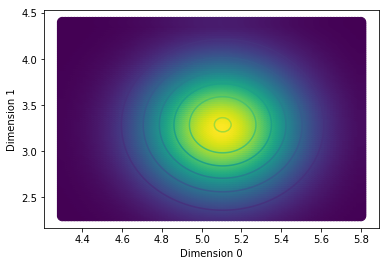

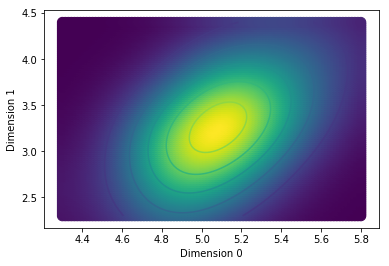

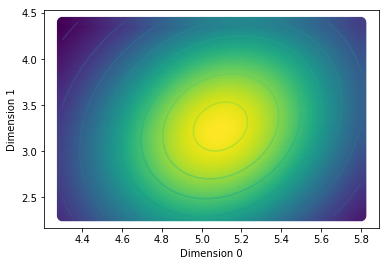

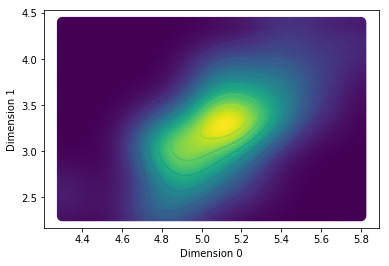

In [23]:
for y in (param_y,parzen_small_y,parzen_big_y,parzen_final_y):
    pylab.scatter(x1_grid, x2_grid ,c = y, s=100)
    pylab.contour(x1_grid,x2_grid,y)
    pylab.xlabel("Dimension " + str(features_chosen[0]))
    pylab.ylabel("Dimension " + str(features_chosen[1]))
    pylab.show()